# Setup

In [64]:
import sys
sys.path.append('..')

import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


import model
from utils.data_utils import Season
from utils.model_utils import Feature
from data.load_footystats import GenerateDataFrame
from data.load_csv import DataLoader
from pipeline.X_table_constructor import XTrainConstructor, XTestConstructor

import shap
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV


In [2]:
df_past1 = GenerateDataFrame(season=Season.Past1).load()
df_past2 = GenerateDataFrame(season=Season.Past2).load()
df_past5 = GenerateDataFrame(season=Season.Past5).load()
df_past10 = GenerateDataFrame(season=Season.Past10).load()

# Preliminary Training

In [76]:
datasets = {
    "P1": df_past1,
    "P2": df_past2,
    "P5": df_past5,
    "P10": df_past10
}

full_feature_params = {
    Feature.GOAL_STATS.value: True,
    Feature.SHOOTING_STATS.value: True,
    Feature.POSSESSION_STATS.value: True,
    Feature.ODDS.value: True,
    Feature.XG.value: True,
    Feature.HOME_AWAY_RESULTS.value: True,
    Feature.CONCEDED_STATS.value: True,
    Feature.LAST_N_MATCHES.value: True,
    Feature.WIN_STREAK.value: True,
    Feature.PAIRWISE_STATS.value: True,
    Feature.PI_RATINGS.value: True,
    Feature.PI_PAIRWISE.value: True,
    Feature.PI_WEIGHTED.value: True
}

team_performance_feature_params = {
    Feature.GOAL_STATS.value: True,
    Feature.SHOOTING_STATS.value: True,
    Feature.POSSESSION_STATS.value: True,
    Feature.HOME_AWAY_RESULTS.value: True,
    Feature.CONCEDED_STATS.value: True,
}

In [26]:
models = {
    "XGB": (full_feature_params, xgb.XGBClassifier(objective="multi:softmax", num_class=3)),
    "CAT": (full_feature_params, CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, loss_function='MultiClass', logging_level='Silent')),
    "SVM": (full_feature_params, SVC(kernel='rbf', C=1, gamma=0.1)),
    "RFC": (full_feature_params, RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)),
    "BENCH": (team_performance_feature_params, SVC(kernel='rbf', C=1, gamma=0.1))
}

In [27]:
# initalise a dict of dicts to store the results for each dataset and model
metrics = ["Accuracy", "F1", "Precision", "Recall", "CrossVal"]
results = { metric: { dataset: { model_name: 0 for model_name in models.keys() } for dataset in datasets.keys() } for metric in metrics }

## Training and Plotting

In [28]:
accuracy_results = { dataset: { model_name: 0 for model_name in models.keys() } for dataset in datasets.keys() }

for dataset_name, df in datasets.items():
    train, test, unique_teams = model.pre_process_data(df)
    X_train_all, y_train, X_test_all, y_test = model.feature_engineering(train, test, unique_teams, full_feature_params)
    X_train_team_performance, _, X_test_team_performance, _ = model.feature_engineering(train, test, unique_teams, team_performance_feature_params)

    for model_name, (feature_params, ml_model) in models.items():
        if model_name == "BENCH":
            X_train, X_test = X_train_team_performance.copy(), X_test_team_performance.copy()
        else:
            X_train, X_test = X_train_all.copy(), X_test_all.copy()

        ml_model.fit(X_train, y_train)
        y_pred = ml_model.predict(X_test)

        results["Accuracy"][dataset_name][model_name] = accuracy_score(y_test, y_pred)
        results["F1"][dataset_name][model_name] = f1_score(y_test, y_pred, average='weighted')
        results["Precision"][dataset_name][model_name] = precision_score(y_test, y_pred, average='weighted')
        results["Recall"][dataset_name][model_name] = recall_score(y_test, y_pred, average='weighted')
        results["CrossVal"][dataset_name][model_name] = cross_val_score(ml_model, X_train, y_train, cv=5, scoring='accuracy').mean()


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


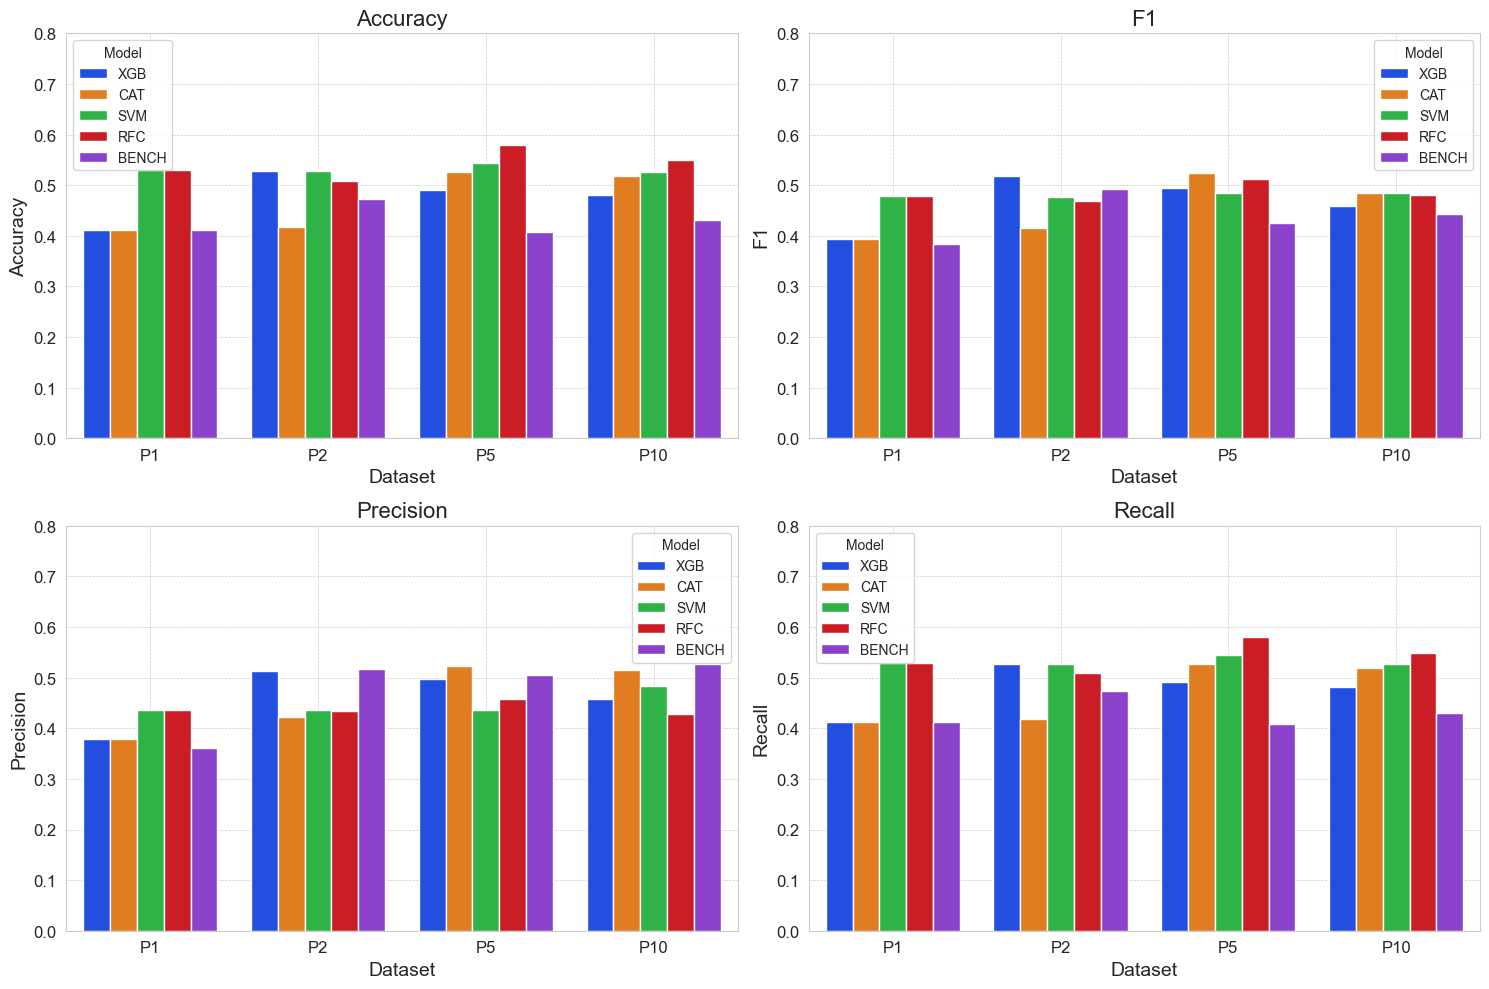

In [128]:
# Plot the results
plt.figure(figsize=(15, 10))

for i, metric, result in zip(range(4), metrics, [results["Accuracy"], results["F1"], results["Precision"], results["Recall"]]):
    df = pd.DataFrame(result)
    df = df.T.reset_index().rename(columns={"index": "Dataset"})
    df = df.melt(id_vars=["Dataset"], var_name="Model", value_name=metric)

    plt.subplot(2, 2, i+1)
    plt.legend(fontsize='large')
    plt.title(metric, fontsize=16)
    sns.barplot(x="Dataset", y=metric, hue="Model", data=df)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel("Dataset", fontsize=14)
    plt.ylabel(metric, fontsize=14)
    plt.ylim(0.0, 0.8)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig("fb_prem_model_results.pdf")
plt.show()


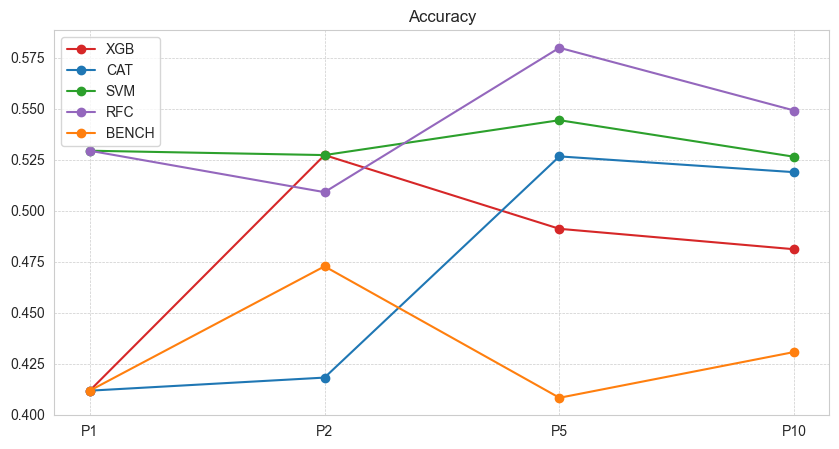

In [131]:
# Plot accuracy results on a line chart
plt.figure(figsize=(10, 5))
df = pd.DataFrame(results["Accuracy"])
df = df.T.reset_index().rename(columns={"index": "Dataset"})
df = df.melt(id_vars=["Dataset"], var_name="Model", value_name="Accuracy")

plt.plot(df[df["Model"] == "XGB"]["Dataset"], df[df["Model"] == "XGB"]["Accuracy"], label="XGB", marker='o', color='tab:red')
plt.plot(df[df["Model"] == "CAT"]["Dataset"], df[df["Model"] == "CAT"]["Accuracy"], label="CAT", marker='o', color='tab:blue')
plt.plot(df[df["Model"] == "SVM"]["Dataset"], df[df["Model"] == "SVM"]["Accuracy"], label="SVM", marker='o', color='tab:green')
plt.plot(df[df["Model"] == "RFC"]["Dataset"], df[df["Model"] == "RFC"]["Accuracy"], label="RFC" , marker='o', color='tab:purple')
plt.plot(df[df["Model"] == "BENCH"]["Dataset"], df[df["Model"] == "BENCH"]["Accuracy"], label="BENCH", marker='o', color='tab:orange')
plt.title("Accuracy")
plt.legend(fontsize='medium')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig("accuracy_results.pdf")
plt.show()

# SHAP Feature Selection

In [77]:
# Prepare the data for the SHAP analysis
train, test, unique_teams = model.pre_process_data(datasets["P5"])
X_train, y_train, X_test, y_test = model.feature_engineering(train, test, unique_teams, full_feature_params)

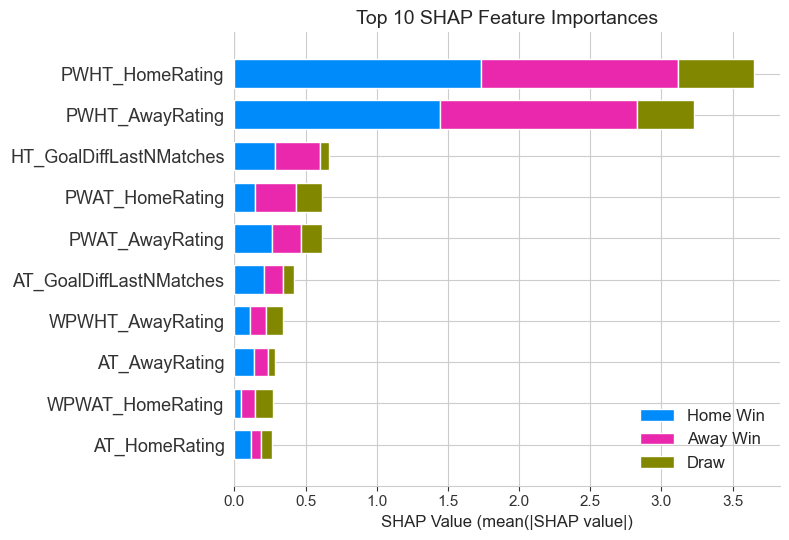

In [121]:
# Train model
cat_model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, loss_function='MultiClass', logging_level='Silent')
cat_model.fit(X_train, y_train)

tree_explainer = shap.TreeExplainer(cat_model)
shap_values = tree_explainer.shap_values(X_train)

shap.initjs()
# plt.figure(figsize=(15, 10))
shap.summary_plot(shap_values, X_train, plot_type='bar', max_display=10, show=False, class_names=["Home Win", "Away Win", "Draw"])
plt.xlabel('SHAP Value (mean(|SHAP value|)', fontsize=12)
plt.title('Top 10 SHAP Feature Importances', fontsize=14, loc='center')
plt.gcf().tight_layout()
plt.savefig('fb_shap_top_10.pdf')
plt.show()

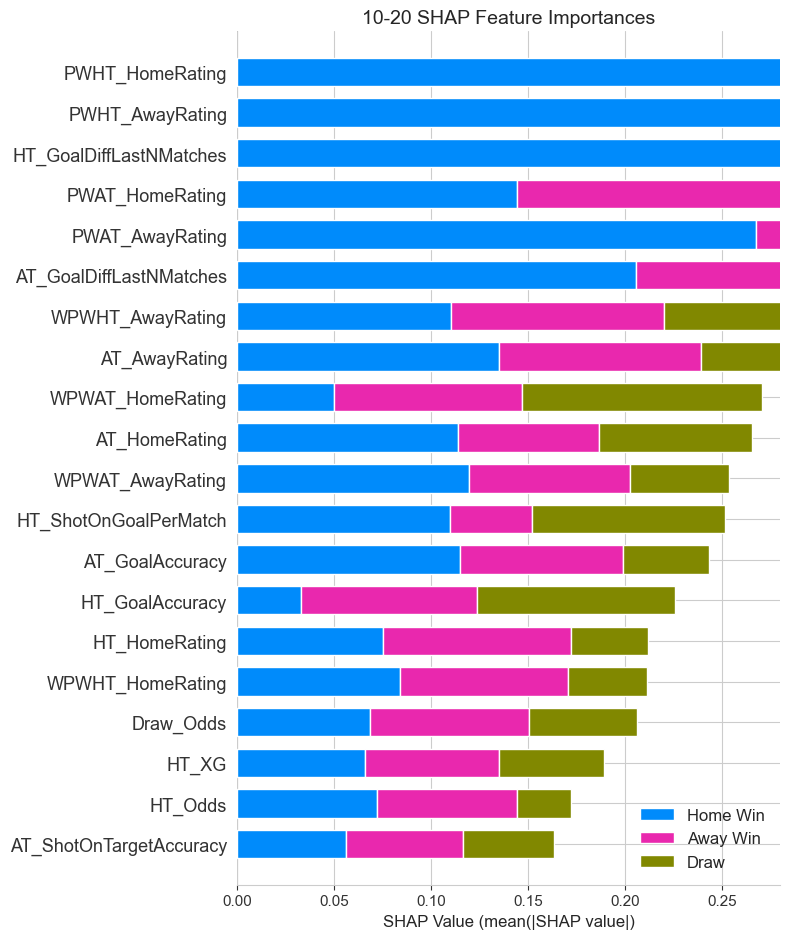

In [122]:
shap.initjs()
shap.summary_plot(shap_values, X_train, plot_type='bar', show=False, class_names=["Home Win", "Away Win", "Draw"])
plt.xlabel('SHAP Value (mean(|SHAP value|)', fontsize=12)
plt.title('10-20 SHAP Feature Importances', fontsize=14, loc='center')
plt.gcf().subplots_adjust(bottom=0.3)
plt.xlim(0, 0.28)
plt.gcf().tight_layout()
plt.savefig('fb_shap_top_10-20.pdf')
plt.show()

# Optimised Retraining

In [164]:
datasets = {
    "P1": df_past1,
    "P2": df_past2,
    "P5": df_past5,
    "P10": df_past10
}

shap_feature_params = {
    Feature.ODDS.value: True,
    Feature.PI_RATINGS.value: True,
    # Feature.PI_PAIRWISE.value: False,
}

In [165]:
models = {
    "XGB": (shap_feature_params, xgb.XGBClassifier(objective="multi:softmax", num_class=3)),
    "CAT": (shap_feature_params, CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, loss_function='MultiClass', logging_level='Silent')),
    "SVM": (shap_feature_params, SVC(kernel='rbf', C=1, gamma=0.1)),
    "RFC": (shap_feature_params, RandomForestClassifier(n_estimators=100, max_depth=10, random_state=1)),
    "BENCH": (team_performance_feature_params, SVC(kernel='rbf', C=1, gamma=0.1))
}

In [166]:
# initalise a dict of dicts to store the results for each dataset and model
metrics = ["Accuracy", "F1", "Precision", "Recall", "CrossVal"]
results = { metric: { dataset: { model_name: 0 for model_name in models.keys() } for dataset in datasets.keys() } for metric in metrics }

In [167]:
accuracy_results = { dataset: { model_name: 0 for model_name in models.keys() } for dataset in datasets.keys() }

for dataset_name, df in datasets.items():
    train, test, unique_teams = model.pre_process_data(df)
    X_train_all, y_train, X_test_all, y_test = model.feature_engineering(train, test, unique_teams, shap_feature_params)
    X_train_team_performance, _, X_test_team_performance, _ = model.feature_engineering(train, test, unique_teams, team_performance_feature_params)

    for model_name, (feature_params, ml_model) in models.items():
        if model_name == "BENCH":
            X_train, X_test = X_train_team_performance.copy(), X_test_team_performance.copy()
        else:
            X_train, X_test = X_train_all.copy(), X_test_all.copy()

        ml_model.fit(X_train, y_train)
        y_pred = ml_model.predict(X_test)

        results["Accuracy"][dataset_name][model_name] = accuracy_score(y_test, y_pred)
        results["F1"][dataset_name][model_name] = f1_score(y_test, y_pred, average='weighted')
        results["Precision"][dataset_name][model_name] = precision_score(y_test, y_pred, average='weighted')
        results["Recall"][dataset_name][model_name] = recall_score(y_test, y_pred, average='weighted')
        results["CrossVal"][dataset_name][model_name] = cross_val_score(ml_model, X_train, y_train, cv=5, scoring='accuracy').mean()


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


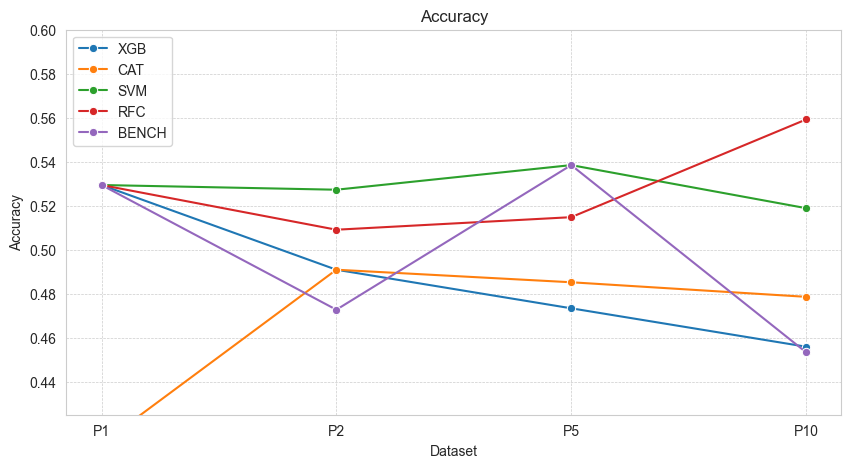

In [168]:
# Plot accuracy results on a line chart
plt.figure(figsize=(10, 5))
df = pd.DataFrame(results["Accuracy"])
df = df.T.reset_index().rename(columns={"index": "Dataset"})
df = df.melt(id_vars=["Dataset"], var_name="Model", value_name="Accuracy")

sns.set_palette("tab10")
sns.lineplot(x="Dataset", y="Accuracy", hue="Model", data=df, marker="o")
plt.title("Accuracy")
plt.legend(fontsize='medium')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.ylim(0.425, .6)
plt.savefig("accuracy_results.pdf")
plt.show()

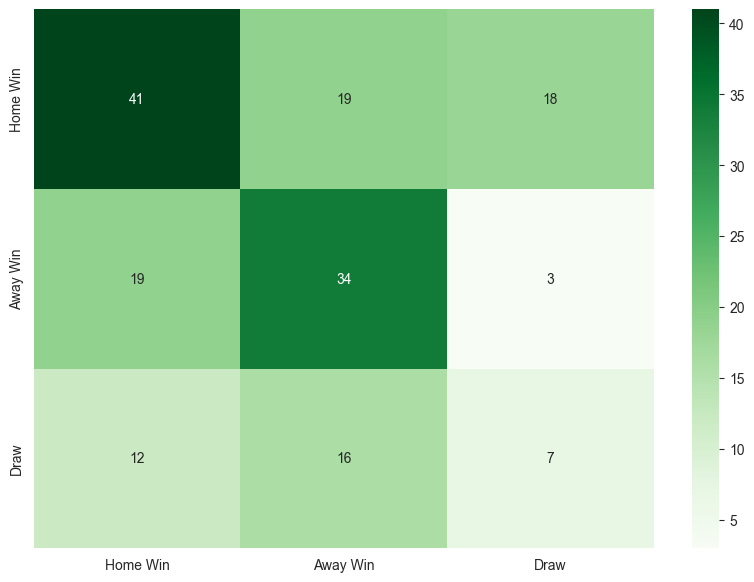

In [174]:
train, test, unique_teams = model.pre_process_data(datasets["P5"])
X_train, y_train, X_test, y_test = model.feature_engineering(train, test, unique_teams, shap_feature_params)

# Train model
cat_model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, loss_function='MultiClass', logging_level='Silent')
cat_model.fit(X_train, y_train)

y_pred = cat_model.predict(X_test)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', xticklabels=["Home Win", "Away Win", "Draw"], yticklabels=["Home Win", "Away Win", "Draw"], cmap='Greens')
plt.savefig("fb_confusion_matrix.pdf")
plt.show()

In [179]:
col1 = results["CrossVal"]
col2 = results["Accuracy"]
col3 = results["F1"]
col4 = results["Precision"]
col5 = results["Recall"]

df1 = pd.DataFrame(col1)
df2 = pd.DataFrame(col2)
df3 = pd.DataFrame(col3)
df4 = pd.DataFrame(col4)
df5 = pd.DataFrame(col5)

df1 = df1.T.reset_index().rename(columns={"index": "Dataset"})
df1 = df1.melt(id_vars=["Dataset"], var_name="Model", value_name="CrossVal")

df2 = df2.T.reset_index().rename(columns={"index": "Dataset"})
df2 = df2.melt(id_vars=["Dataset"], var_name="Model", value_name="Accuracy")

df3 = df3.T.reset_index().rename(columns={"index": "Dataset"})
df3 = df3.melt(id_vars=["Dataset"], var_name="Model", value_name="F1")

df4 = df4.T.reset_index().rename(columns={"index": "Dataset"})
df4 = df4.melt(id_vars=["Dataset"], var_name="Model", value_name="Precision")

df5 = df5.T.reset_index().rename(columns={"index": "Dataset"})
df5 = df5.melt(id_vars=["Dataset"], var_name="Model", value_name="Recall")

df = pd.merge(df1, df2, on=["Dataset", "Model"])
df = pd.merge(df, df3, on=["Dataset", "Model"])
df = pd.merge(df, df4, on=["Dataset", "Model"])
df = pd.merge(df, df5, on=["Dataset", "Model"])

df.to_csv("fb_results.csv", index=False)